# EEG preprocessing

This notebook is used to preprocess individual trials. The process goes as follows:
1. Import `xdf` data file from the `Data` folder.
2. High-pass filter the data. As recommended [here](https://sccn.ucsd.edu/githubwiki/files/ICA_Theory_EEGLAB2021.pdf) tom improve the following ICA decomposition.
3. Run ICA and manually select components to remove
4. Low-pass filter the data.
5. Save all configurations in a `json` file with the same name as the data file that was preprocessed.

Note that each code cell has some settings at the top. These settings are saved to the `json` file for future batch processing.

Thiere are 3 steps that must be done manually:
1. in the 'remove bad channels' cell, look at the raw data and identify any potentially bad channels. Must update the channels to remove and the ch_names list.
2. after "ica.plot_components" identify which components to look more closely at and add them to ch_properties in the "Plot ICA properties" cell
3. decide which components to remove and add them to ica_exclude in the "Remove ICA components" cell

## Import libraries


In [1]:
# Standard libraries
import mne
import json
from mne.preprocessing import ICA

# Custom libraries
from Functions import import_data

# Enable interactive plots
%matplotlib qt

## Import data

Import a single data file and extract the EEG signal as a `np.ndarray`. Create a `MNE` array for further processing.

In [2]:
# Settings
file_name = "sub-P004_ses-S001_task-T1_run-001_eeg.xdf"
ch_names = ["C3", "Cz", "C4", "T7", "T8", "P3", "Pz", "P4", "P7", "PO7", "POz", "P8", "PO8", "O1", "Oz", "O2"]

# Import data
[eeg_ts, eeg_data, eeg_fs] = import_data.read_xdf(f"Data\\{file_name}", picks=ch_names)

# Create MNE array
info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties
mne_raw = mne.io.RawArray(eeg_data, info = info)            # Create MNE raw array
mne_raw.set_montage('standard_1020')                        # Set montage to array

Creating RawArray with float64 data, n_channels=16, n_times=1007744
    Range : 0 ... 1007743 =      0.000 ...  3936.496 secs
Ready.


<RawArray | 16 x 1007744 (3936.5 s), ~123.0 MB, data loaded>

## Visualize raw data

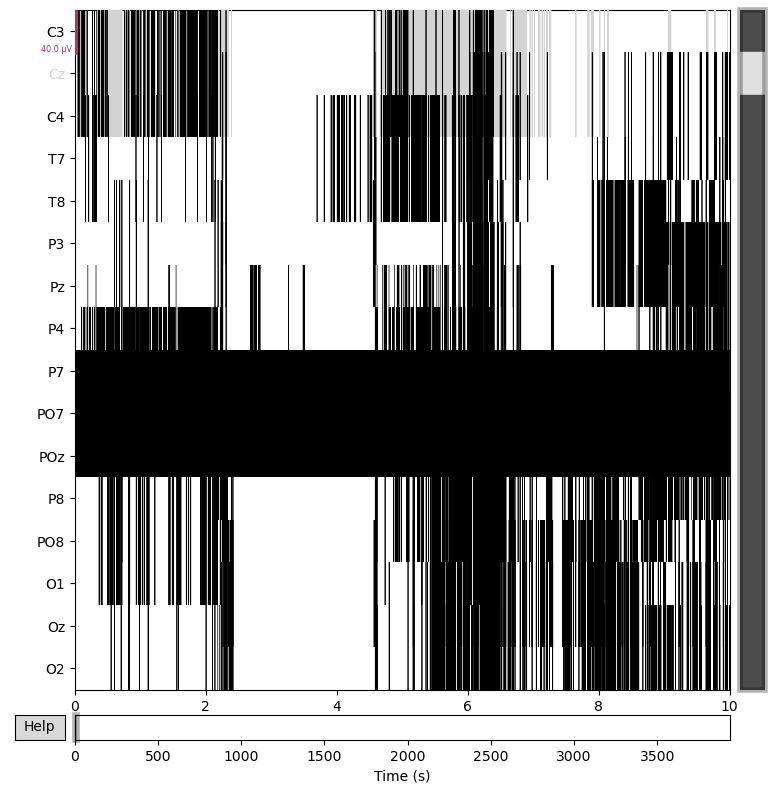

Channels marked as bad:
none


In [4]:
mne_raw.plot(title="RAW data")

## Remove bad channels manually 

Using the previous plot, identify which channels are "bad" and include them in the following list.

In [9]:
a = []

a.extend(["1"])

In [18]:
len(ch_names)

15

The channel PO7 does not exist in ch_names


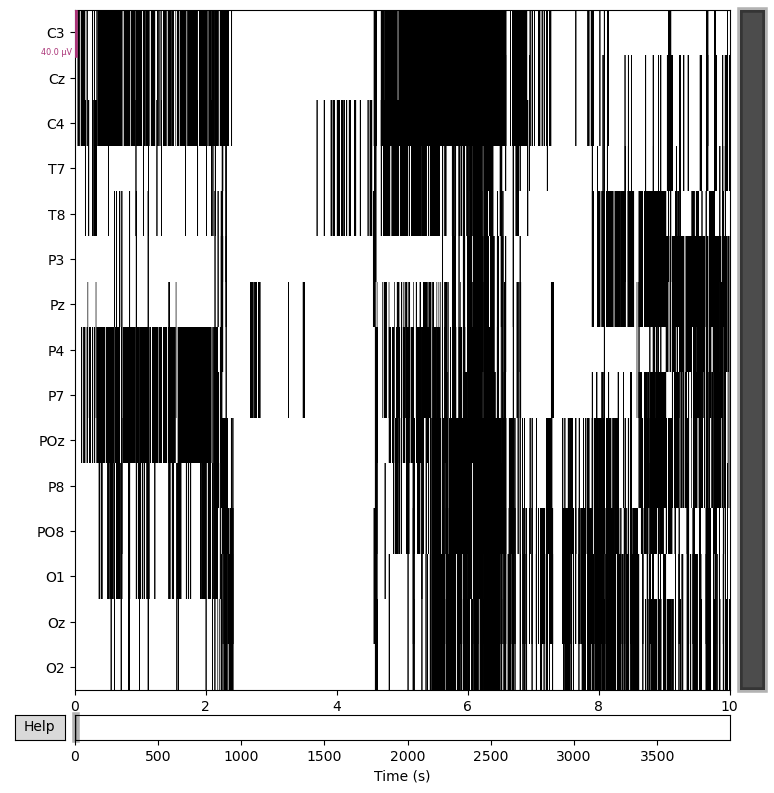

In [20]:
# Settings
bad_chans = ["PO7"] # Names of bad channels - list[str]

# Remove channels from ch_names list
for chan in bad_chans:
    try:
        ch_names.remove(chan)
    except:
        print(f"The channel {chan} does not exist in ch_names")

# Mark bad channels in MNE object and remove
mne_raw.info['bads'].extend(bad_chans)
mne_raw_rm_chans = mne_raw.copy().pick(ch_names)

# Enable this to visualize RAW data with bad channels removed
# mne_raw_rm_chans.plot(title="RAW without bad channels")

## High-pass filter data

Apply a high-pass filter to remove large drifts and make ICA more stable as noted [here](https://sccn.ucsd.edu/githubwiki/files/ICA_Theory_EEGLAB2021.pdf).

In [4]:
# Settings
hpf_fc = 0.5    # High-pass cut-off frequency: list[Hz]

# Apply high-pass filter
filt_raw = mne_raw_rm_chans.copy().filter(l_freq=hpf_fc, h_freq=None, picks=ch_names)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


## Independent Component Analysis

### Perform ICA

Perform ICA on the high-pass filtered data and manually select the components to be removed. A tutorial for the `MNE` ICA processing can be found [here](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html).

In [5]:
# Settings
n_components = len(filt_raw.ch_names)   # Number of components for ICA [n]
random_state = 97                       # Random state for reproducible results
max_iter = "auto"                       # Max number of iterations

# Create and apply ICA
ica = ICA(
    n_components = n_components,
    max_iter = max_iter,
    random_state = random_state
    )

ica.fit(filt_raw, picks = ch_names)
ica


Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 25.4s.


Method,fastica
Fit,56 iterations on raw data (1007744 samples)
ICA components,15
Available PCA components,15
Channel types,eeg
ICA components marked for exclusion,—


### Plot ICA topography

Plot the topography to select which components to exclude.

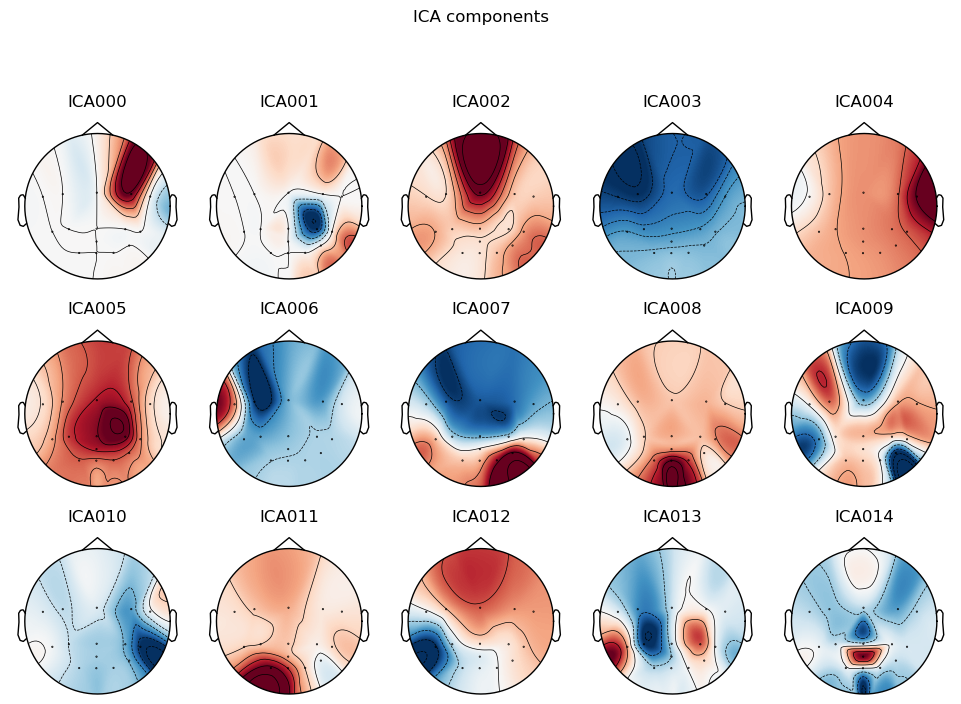

In [6]:
# Plot ICA components on interactive plot
ica.plot_components()

### Plot ICA properties

Select a single channel to further inspect its properties and decide whether it should be excluded or not.

In [7]:
# Settings 
ch_properties = [0,1,2,3,4,5,6,7,8]  # Channels to inspect list[int]

# Plot ICA properties
ica.plot_properties(filt_raw, picks = ch_properties, verbose = False)

# Compute amount of variance explained by each component to inspect
print("Variance explained")
for component in ch_properties:
    explained_var_ratio = ica.get_explained_variance_ratio(
        filt_raw, 
        components=component,
        ch_type="eeg"
    )
    
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    print(f"- Component {component}: variance = {ratio_percent}%")

Variance explained
- Component 0: variance = 95%
- Component 1: variance = 5%
- Component 2: variance = 0%
- Component 3: variance = 0%
- Component 4: variance = 0%
- Component 5: variance = 0%
- Component 6: variance = 0%
- Component 7: variance = 0%
- Component 8: variance = 0%


### Remove ICA components

After analyzing the topography and properties of the components to remove, create a list of components to be removed and plot the time series.

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 15 PCA components


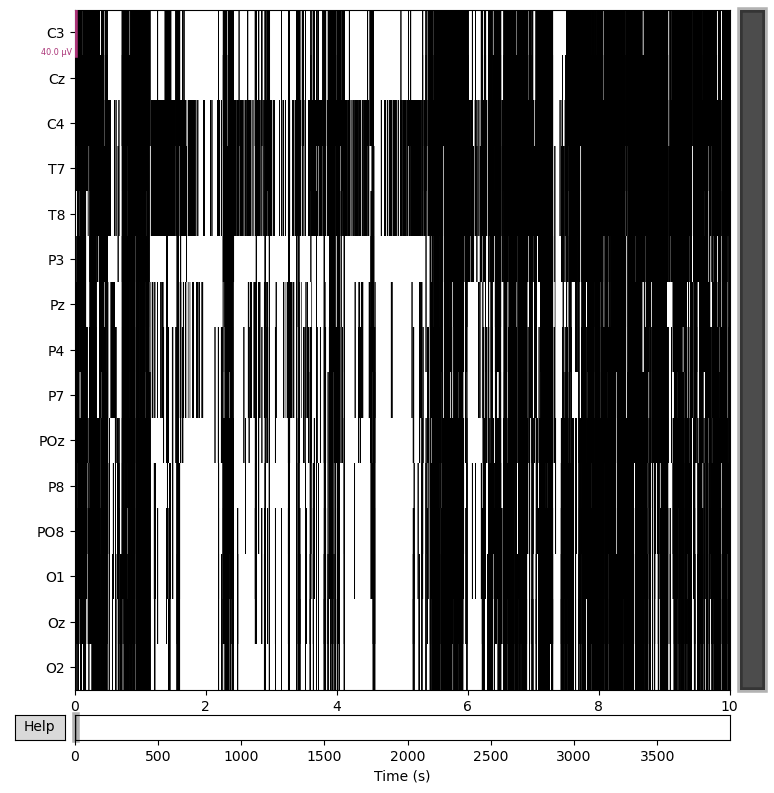

In [8]:
# Settings
ica_exclude = [0, 2] # List of components to be removed list[int]

# Remove components
raw_ica = filt_raw.copy()
ica.exclude = ica_exclude
ica.apply(raw_ica)

# Plot before and after ICA to compare
filt_raw.plot(title="HPF before ICA")
raw_ica.plot(title="HPF after ICA")

## Low-pass filter data

Finally, apply low-pass filter to the data after removing ICA components.

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 85 samples (0.332 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished


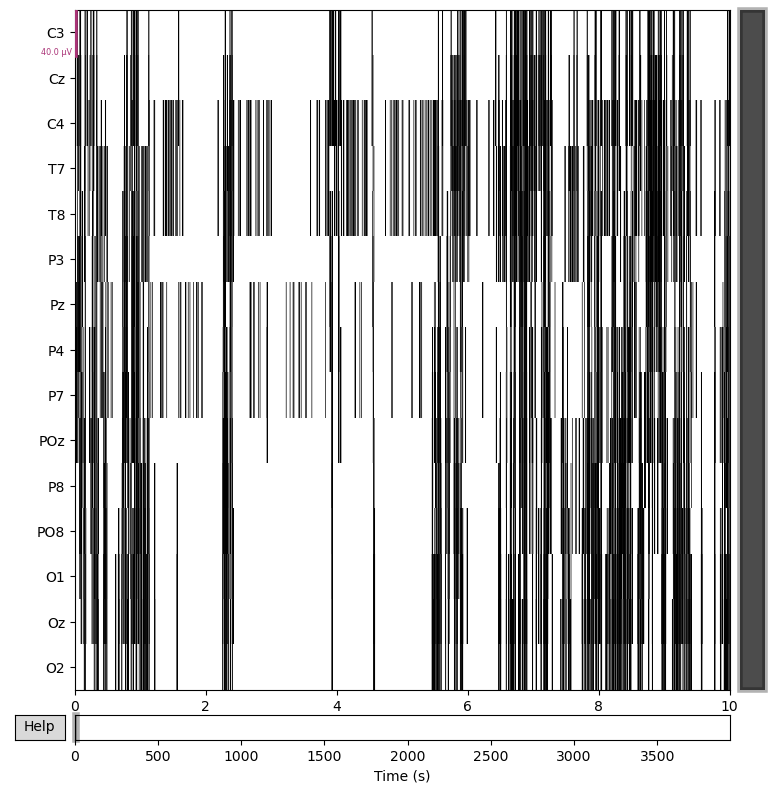

In [9]:
# Settings 
lpf_fc = 40 # Cut-off frequency of low-pass filter [Hz]

# Apply filter and plot data
band_raw = filt_raw.copy().filter(l_freq=None, h_freq=lpf_fc, picks=ch_names)
band_raw.plot(title="HPF + ICA + LPF")

## Save settings

Save all the settings to a `json` file for batch processing.

In [11]:
# Settings
save_model = True

if (save_model):
    json_data = {
        "file_name": file_name,
        "ch_names": ch_names,
        "bad_chans": bad_chans,
        "hpf_fc": hpf_fc,
        "lpf_fc": lpf_fc,
        "ica_exclude": ica_exclude,
        "n_components": n_components,
        "random_state": random_state,
        "max_iter": max_iter
    }

    # Get file name without extension
    json_file_name = file_name.split("\\")[-1].split(".")[0]
    
    # Write dictionary to json file
    with open(f"Data\{json_file_name}.json", "w") as f:
        json.dump(json_data, f)